# diagnoses_icd

In [1]:
import pandas as pd

In [2]:
diagnoses = pd.read_csv('/data/share/AKI/3.0/hosp/diagnoses_icd.csv.gz', compression = 'gzip')

In [3]:
diagnoses.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version'], dtype='object')

In [4]:
print(diagnoses.head(10))
print('-----------------')
print(diagnoses.shape)

   subject_id   hadm_id  seq_num icd_code  icd_version
0    10000032  22595853        1     5723            9
1    10000032  22595853        2    78959            9
2    10000032  22595853        3     5715            9
3    10000032  22595853        4    07070            9
4    10000032  22595853        5      496            9
5    10000032  22595853        6    29680            9
6    10000032  22595853        7    30981            9
7    10000032  22595853        8    V1582            9
8    10000032  22841357        1    07071            9
9    10000032  22841357        2    78959            9
-----------------
(6364520, 5)


In [5]:
target_value = ['5845', '5846', '5847', '5848', '5849', '66930', '66932', '66934', 'N17', 'N170', 'N171', 'N172', 'N178', 'N179', 'Q904']

In [6]:
diagnoses = diagnoses.drop(['seq_num', 'icd_version'], axis = 1)

In [7]:
diagnoses['target'] = diagnoses['icd_code'].apply(lambda x : 1 if x in target_value else 0)
diagnoses['target'].value_counts() 
"""
without AKI 0.99
with AKI 0.01
"""

'\nwithout AKI 0.99\nwith AKI 0.01\n'

In [8]:
aki_list = diagnoses[diagnoses['target'] == 1]['hadm_id'].unique()
not_aki_list = diagnoses[diagnoses['target'] == 0]['hadm_id'].unique()

# Procedureevents

In [9]:
import gc
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

icu_path = '/data/share/AKI/3.0/icu/'
label_data = pd.read_csv('/home/stateun/aki_hadm.csv')

label_subject = label_data['subject_id']
label_hadm = label_data['hadm_id']
label_aki = label_data['aki']

In [10]:
procedureevents = pd.read_csv('/data/share/AKI/3.0/icu/procedureevents.csv.gz', compression = 'gzip')

In [11]:
procedureevents.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime', 'itemid', 'value', 'valueuom', 'location',
       'locationcategory', 'orderid', 'linkorderid', 'ordercategoryname',
       'ordercategorydescription', 'patientweight', 'isopenbag',
       'continueinnextdept', 'statusdescription', 'originalamount',
       'originalrate'],
      dtype='object')

In [12]:
procedureevents = procedureevents.drop([ 'stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime',  'valueuom', 'location',
       'locationcategory', 'orderid', 'linkorderid', 'ordercategoryname',
       'ordercategorydescription', 'patientweight', 'isopenbag',
       'continueinnextdept', 'statusdescription', 'originalamount',
       'originalrate'], axis= 1)

In [13]:
# Check the nan value
sum(procedureevents['value'].isna())

0

In [15]:
procedureevents['value'].dtypes

dtype('float64')

In [16]:
"""
Check the Outlier
"""

def compute_stats(group):
    min_val = group.min()
    max_val = group.max()
    mean = group.mean()
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    return pd.Series({'min': min_val, 'max': max_val,'mean' : mean, 'Q1-1.5*IQR' : lower_fence ,'Q3+1.5*IQR': upper_fence})

stats = procedureevents.groupby('itemid')['value'].apply(compute_stats).unstack().reset_index()
stats.head(20)

,itemid,min,max,mean,Q1-1.5*IQR,Q3+1.5*IQR
0,221214,1.000000,1.0,1.000000,1.000,1.000
1,221216,1.000000,1.0,1.000000,1.000,1.000
2,221217,1.000000,1.0,1.000000,1.000,1.000
3,221219,1.000000,1.0,1.000000,1.000,1.000
4,221223,1.000000,1.0,1.000000,1.000,1.000
5,221255,1.000000,1.0,1.000000,1.000,1.000
6,223253,1.000000,1.0,1.000000,1.000,1.000
7,224263,0.029861,100740.0,5165.319858,-6206.125,14196.875
8,224264,0.004861,172949.0,6117.822138,-7736.500,16759.500
9,224267,0.115278,39002.0,3059.468616,-2787.250,8066.750


{'whiskers': [<matplotlib.lines.Line2D at 0x7feb6130f4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7feb6b53dc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7feb61307c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7feb61370f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7feb61315b50>],
 'means': []}

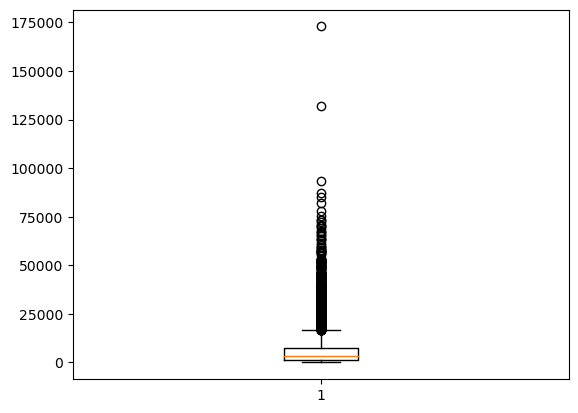

In [19]:
plt.boxplot(procedureevents[(procedureevents['itemid'] == 224264)]['value'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7feb6082f3a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7feb6082f8e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7feb6082f100>],
 'medians': [<matplotlib.lines.Line2D at 0x7feb6082fe20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7feb607bc100>],
 'means': []}

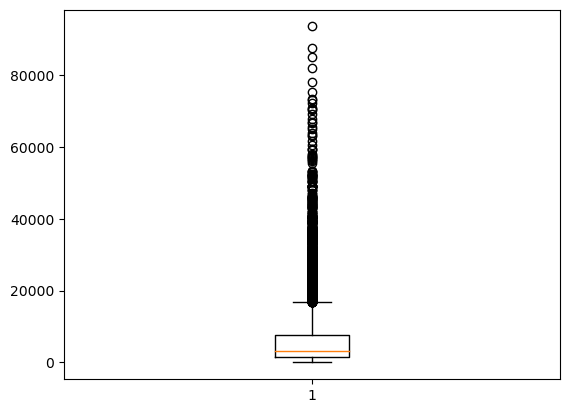

In [23]:
plt.boxplot(procedureevents[(procedureevents['itemid'] ==  224264) & (procedureevents['value'] < 100000)]['value'])

In [25]:
"""
Remove the Outlier
"""

procedureevents = pd.read_csv(icu_path + 'procedureevents.csv.gz', compression='gzip', chunksize=10**6)

for i, chunk in enumerate(tqdm(procedureevents, desc='Processing chunks')):

    chunk = chunk.merge(stats[['itemid', 'Q1-1.5*IQR', 'Q3+1.5*IQR']], on='itemid', how='left')
    chunk.head(5)

    chunk.dropna(subset=['Q1-1.5*IQR', 'Q3+1.5*IQR'], inplace=True)

    mask = (chunk['value'] >= chunk['Q1-1.5*IQR']) & (chunk['value'] <= chunk['Q3+1.5*IQR'])
    chunk = chunk[mask]

    chunk.drop(['Q1-1.5*IQR', 'Q3+1.5*IQR'], axis=1, inplace=True)

    chunk.to_csv(f'preprocessing_procedureevents_{i}.csv', index=False)
    
    print(f'{i}-th preprocessing complete.')

    del chunk
    gc.collect()

Processing chunks: 1it [00:09,  9.73s/it]

0-th preprocessing complete.


In [48]:
procedureevents = pd.read_csv('/home/stateun/preprocessing_procedureevents_0.csv')

In [49]:
aki_hadms = procedureevents.loc[procedureevents['hadm_id'].isin(aki_list)]['hadm_id'].unique().tolist()

In [50]:
hadm_ids = procedureevents.hadm_id.unique().tolist()
aki_hadms_set = set(aki_hadms)
hadm_aki_dict = {'hadm_id' : hadm_ids, 'aki':[int(h in aki_hadms_set) for h in hadm_ids]}
hadm_aki_df = pd.DataFrame(hadm_aki_dict)

In [51]:
# 1
procedureevents['aki'] = procedureevents['hadm_id'].apply(lambda x : 1 if  x in aki_list else 0)

In [52]:
# 2
procedureevents['aki'] = procedureevents['hadm_id'].isin(aki_list).astype(int)

In [53]:
procedureevents_icd = procedureevents[['subject_id', 'hadm_id']].drop_duplicates()
hadm_to_subject = {str(h):s for s, h in zip(procedureevents_icd.subject_id.tolist(), procedureevents_icd.hadm_id.tolist())}
aki_subject = [s for h, s in hadm_to_subject.items() if int(h) in aki_hadms_set]

In [54]:
# Simple code
aki_subject = procedureevents[procedureevents['hadm_id'].isin(aki_list)]['subject_id'].tolist()

In [55]:
aki_subject_set = set(aki_subject)

In [56]:
aki_first_prev_hadm = []
aki_last_prev_hadm = []
aki_subject_for_check = []
for key, df in tqdm(procedureevents_icd.groupby(by = ['subject_id'])):
    had_aki = list(set(df.hadm_id).intersection(aki_hadms_set))
    if had_aki:
        first_h = np.array(had_aki).min()
        last_h = np.array(had_aki).max()
        first_prev_h = df.loc[df.hadm_id <= first_h, 'hadm_id'].tolist()
        last_prev_h = df.loc[df.hadm_id <= last_h, 'hadm_id'].tolist()
        aki_first_prev_hadm.extend(first_prev_h)
        aki_last_prev_hadm.append(last_prev_h)
        aki_subject_for_check.append(key)

  0%|          | 0/58750 [00:00<?, ?it/s]/usr/local/anaconda3/envs/latest/lib/python3.9/site-packages/tqdm/std.py:1195: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for obj in iterable:
100%|██████████| 58750/58750 [00:11<00:00, 5267.93it/s]


In [57]:
from statsmodels.stats.proportion import proportions_ztest

In [58]:
def do_everything3(df, colname, val_colname):
    # Exclude rows where 'hadm_id' is null
    df = df.loc[~df['hadm_id'].isnull(), :]

    # Create 'is_aki' column to identify AKI subjects
    df['is_aki'] = df['subject_id'].isin(aki_subject_set)

    # Calculate the number of unique hadm_ids
    n_hadms = df['hadm_id'].nunique()
    n_aki_hadms = df.loc[df['is_aki'], 'hadm_id'].nunique()
    print(f'# unique aki hadms : {n_aki_hadms}\n# unique hadms : {n_hadms}')

    # Get unique combinations of 'hadm_id' and 'colname'
    colname_hadm = df[['hadm_id', colname]].drop_duplicates()
    colname_aki_hadm = df.loc[df['is_aki'], ['hadm_id', colname]].drop_duplicates()

    # Compute counts of hadm_ids per colname
    colname_hadm_counts = colname_hadm.groupby(colname)['hadm_id'].count()
    colname_aki_hadm_counts = colname_aki_hadm.groupby(colname)['hadm_id'].count()

    # Align indices
    colname_all = colname_hadm_counts.index.union(colname_aki_hadm_counts.index)
    colname_hadm_counts = colname_hadm_counts.reindex(colname_all, fill_value=0)
    colname_aki_hadm_counts = colname_aki_hadm_counts.reindex(colname_all, fill_value=0)

    # Perform z-test for proportions
    code_test_pval = {}
    print(f'Calculating p-values for every code...')
    for k in tqdm(colname_all):
        counts = np.array([colname_aki_hadm_counts[k], colname_hadm_counts[k] - colname_aki_hadm_counts[k]])
        nobs = np.array([n_aki_hadms, n_hadms - n_aki_hadms])

        if 0 not in nobs:
            if 0 not in counts:
                stat, pval = proportions_ztest(counts, nobs)
                code_test_pval[k] = pval
            elif counts[1] == 0:
                code_test_pval[k] = 0
            else:
                print(f'Code {k} has 0 counts in AKI... wrong counting')
        else:
            print(f'Zero in nobs for code {k}')

    aki_code_top = {k for k, v in code_test_pval.items() if v < 0.05}
    print(f'There are {len(aki_code_top)} codes with p-value < 0.05.')

    # Select codes with counts greater than the mean
    code_top = colname_hadm_counts[colname_hadm_counts > colname_hadm_counts.mean()].index
    print(f'# codes with count larger than mean: {len(code_top)}')

    # Intersection of codes with p-value < 0.05 and counts > mean
    final_aki_code_top = aki_code_top.intersection(code_top)
    print(f'Finally, we got {len(final_aki_code_top)} codes to maintain.')

    fact = list(final_aki_code_top)

    # Create a new dataframe using pivot
    print('\nCreating new dataframe...')
    df_filtered = df[df[colname].isin(fact)]
    grouped = df_filtered.groupby(['subject_id', 'hadm_id', colname])[val_colname].mean().reset_index()
    pivot_df = grouped.pivot(index=['subject_id', 'hadm_id'], columns=colname, values=val_colname).reset_index()
    pivot_df = pivot_df.fillna(0)

    # Prompt for column name prefix
    prefix = input('Column name prefix: ')

    # Rename columns
    new_colnames = ['value_' + prefix + '_' + str(c) for c in pivot_df.columns if c not in ['subject_id', 'hadm_id']]
    pivot_df.columns = ['subject_id', 'hadm_id'] + new_colnames

    final_df = pivot_df

    return final_aki_code_top, final_df

In [59]:
def convert_to_datetime(datestr : str) :
    if ':' in datestr:
        date_time = datetime.datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S')
    else :
        date_time = datetime.datetime.strptime(datestr, '%Y-%m-%d')
    return date_time
procedureevents['hrs'] = (procedureevents.starttime.apply(lambda x : convert_to_datetime(x)) - procedureevents.endtime.apply(lambda x : convert_to_datetime(x))).apply(lambda x : round(x.seconds/3600))

In [65]:
procedureevents.columns

Index(['subject_id', 'hadm_id', 'itemid', 'value', 'aki', 'hrs'], dtype='object')

In [64]:
procedureevents = procedureevents.drop(['stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime', 'valueuom', 'location',
       'locationcategory', 'orderid', 'linkorderid', 'ordercategoryname',
       'ordercategorydescription', 'patientweight', 'isopenbag',
       'continueinnextdept', 'statusdescription', 'originalamount',
       'originalrate'], axis=1)

KeyError: "['stay_id', 'caregiver_id', 'starttime', 'endtime', 'storetime', 'valueuom', 'location', 'locationcategory', 'orderid', 'linkorderid', 'ordercategoryname', 'ordercategorydescription', 'patientweight', 'isopenbag', 'continueinnextdept', 'statusdescription', 'originalamount', 'originalrate'] not found in axis"

In [66]:
procedureevents.columns

Index(['subject_id', 'hadm_id', 'itemid', 'value', 'aki', 'hrs'], dtype='object')

In [67]:
list, data = do_everything3(procedureevents, 'itemid', 'value')

# unique aki hadms : 29746
# unique hadms : 76604
Calculating p-values for every code...


100%|██████████| 159/159 [00:00<00:00, 5281.29it/s]

Code 229522 has 0 counts in AKI... wrong counting
There are 129 codes with p-value < 0.05.
# codes with count larger than mean: 32
Finally, we got 31 codes to maintain.

Creating new dataframe...


In [69]:
data.to_csv('final_procedureevents.csv', index = False)

os.remove('preprocessing_procedureevents_0.csv')